<a href="https://colab.research.google.com/github/comHack/Mammography_DL_Classification/blob/master/Models/model_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.applications import ResNet50

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import pickle

import os

import random

from google.colab import drive

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

# **Mounting Drive**

In [ ]:
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')

Mounted at /gdrive


# **Import Data**

## **Process data**
Create own data distribution (with own shuffle)

In [ ]:
# setting the path to the pickle files saved  (grayscale images)
benign_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/benign_3.pickle"

malign_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/malign_3.pickle"

In [ ]:
# opening pickle files (grayscale images)
pickle_in = open(benign_link, "rb")
benign_data = pickle.load(pickle_in)

pickle_in = open(malign_link, "rb")
malign_data = pickle.load(pickle_in)

In [ ]:
# shuffle the data
random.shuffle(benign_data)
random.shuffle(malign_data)

In [ ]:
# splitting and merging the data from benign and malign arrays

# split eg. train_per = 0.7 --> 70% train data, 30% test data
train_per = 0.7

trn_b = int(len(benign_data) * train_per)

trn_m = int(len(malign_data) * train_per)

train_data = benign_data[: trn_b].copy() + malign_data[: trn_m].copy()

test_data = benign_data[trn_b :].copy() + malign_data[trn_m :].copy()

In [ ]:
# shuffle train and test data
random.shuffle(train_data)
random.shuffle(test_data)

In [ ]:
assert len(train_data + test_data) == len(benign_data + malign_data)

In [ ]:
# separating the features and labels

X_train = []
y_train = []

X_test = []
y_test = []

for X, y in train_data:
  X_train.append(X)
  y_train.append(y)

for X, y in test_data:
  X_test.append(X)
  y_test.append(y)


In [ ]:
# reshaping 

num_channels = 1 # depend whether you're using rgb or grayscale images

IMG_SIZE = len(X_train[0])

X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, num_channels)

y_train = np.array(y_train).reshape(-1)

IMG_SIZE = len(X_test[0])

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, num_channels)

y_test = np.array(y_test).reshape(-1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

**Scaling**

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

## **Import processed data**
Use the same data distribution

In [ ]:
# setting the path to the pickle files saved  (grayscale images)
X_train_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/X_train_3.pickle"

y_train_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/y_train_3.pickle"

X_test_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/X_test_3.pickle"

y_test_link = "/content/gdrive/Copy of BCD/Breast Cancer Detection/Pickle files of images/RGB IMAGES ARRAY/y_test_3.pickle"

In [ ]:
pickle_in = open(X_train_link, "rb")
X_train = pickle.load(pickle_in)

pickle_in = open(y_train_link, "rb")
y_train = pickle.load(pickle_in)

pickle_in = open(X_test_link, "rb")
X_test = pickle.load(pickle_in)

pickle_in = open(y_test_link, "rb")
y_test = pickle.load(pickle_in)

# **Setting up models**

### **model_resnet**

#### **resnet_1**

In [ ]:
resnet = ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3)
    )
# resnet.trainable = False

for layer in resnet.layers:
  layer.trainable = False

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
last_layer = resnet.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 2048)


In [ ]:
x = Flatten()(last_output)

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(resnet.input, outputs=x)


In [ ]:
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['acc']
)

In [ ]:
result = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_split = 0.3,
    verbose = 2
)

Epoch 1/100
62/62 - 3s - loss: 0.8289 - acc: 0.5090 - val_loss: 0.6944 - val_acc: 0.4284
Epoch 2/100
62/62 - 3s - loss: 0.6934 - acc: 0.5023 - val_loss: 0.6936 - val_acc: 0.4845
Epoch 3/100
62/62 - 3s - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6934 - val_acc: 0.4845
Epoch 4/100
62/62 - 3s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6935 - val_acc: 0.4845
Epoch 5/100
62/62 - 3s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6936 - val_acc: 0.4845
Epoch 6/100
62/62 - 3s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6937 - val_acc: 0.4845
Epoch 7/100
62/62 - 3s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6935 - val_acc: 0.4845
Epoch 8/100
62/62 - 3s - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6936 - val_acc: 0.4845
Epoch 9/100
62/62 - 3s - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6935 - val_acc: 0.4845
Epoch 10/100
62/62 - 3s - loss: 0.6931 - acc: 0.5044 - val_loss: 0.6934 - val_acc: 0.4845
Epoch 11/100
62/62 - 3s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6935 - val_acc: 0.4845
Epoch 12/100
62/62 

In [ ]:
outputs = [layer.output for layer in model.layers[0:]]

model_vis = tf.keras.models.Model(inputs = model.input, outputs = outputs)

x = random.choice(X_test)
x   = x.reshape((1,) + x.shape)

feature_maps = model_vis.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, feature_maps):
  
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]
    size       = feature_map.shape[ 1]
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [ ]:
resEv_model = model.evaluate(X_test, y_test, 20)
print('test loss, test acc:', resEv_model)

60/60 [==============================] - 1s 21ms/step - loss: 0.6932 - acc: 0.4987
test loss, test acc: [0.693225085735321, 0.4987468719482422]


In [ ]:
y_Pred = model.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, np.rint(y_Pred)))
print(accuracy_score(y_test, np.rint(y_Pred)))
print(recall_score(y_test, np.rint(y_Pred), average=None))
print(precision_score(y_test, np.rint(y_Pred), average=None))

[[597   0]
 [600   0]]
0.49874686716791977
[1. 0.]
[0.49874687 0.        ]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


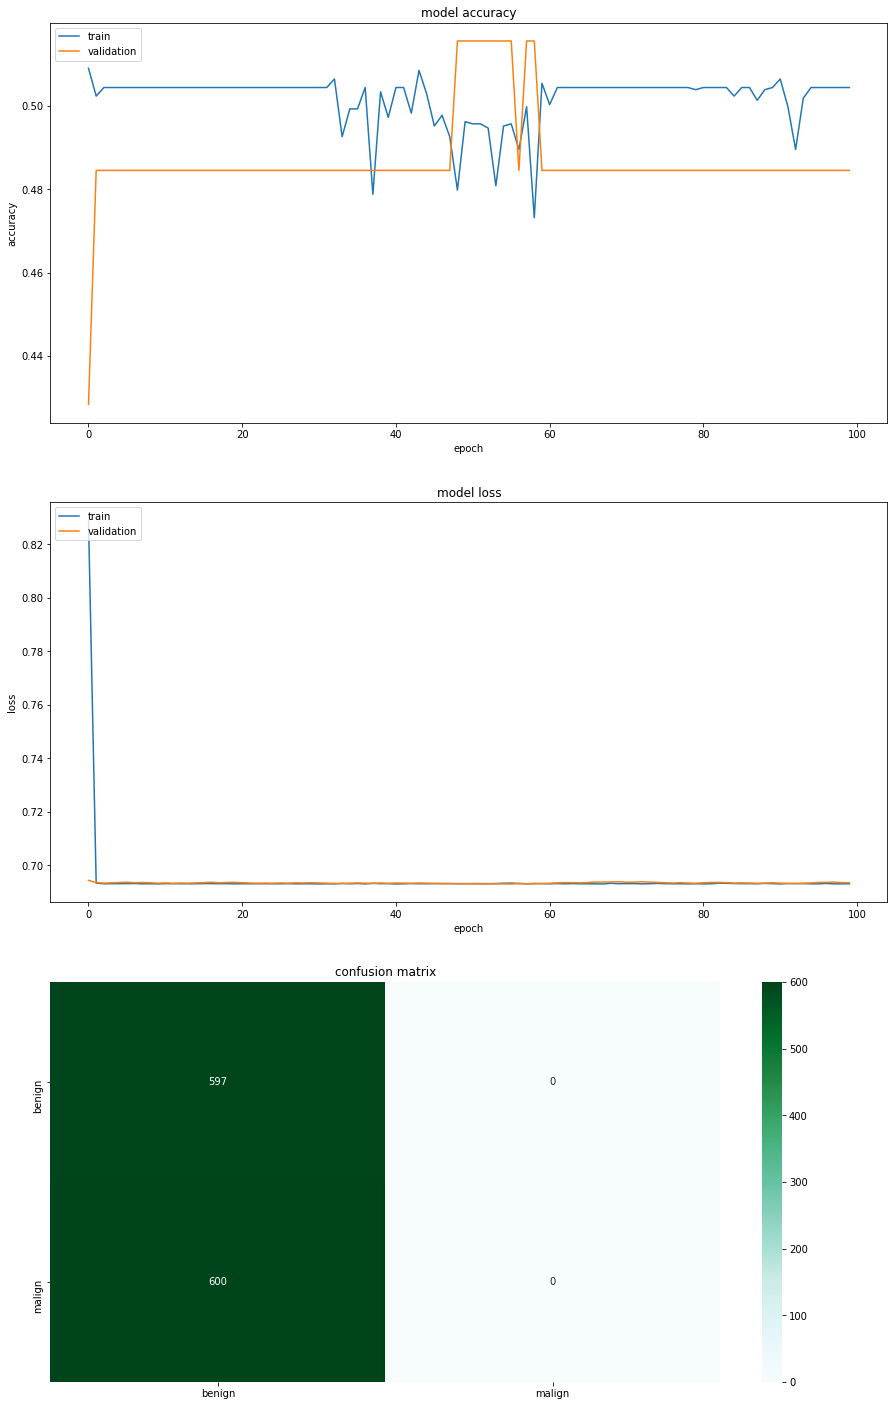

In [ ]:
class_names = ['benign', 'malign']

cm = pd.DataFrame(confusion_matrix(y_test, np.rint(y_Pred)), 
                  index = class_names,
                  columns = class_names)

metrics_values = [ [confusion_matrix(y_test, np.rint(y_Pred))],
            [accuracy_score(y_test, np.rint(y_Pred))],
            [recall_score(y_test, np.rint(y_Pred), average=None)],
            [precision_score(y_test, np.rint(y_Pred), average=None)]]

fig, ax = plt.subplots(3, 1, figsize = (15, 25))

ax[0].plot(result.history['acc'])
ax[0].plot(result.history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='upper left')

ax[1].plot(result.history['loss'])
ax[1].plot(result.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='upper left')

hm = sn.heatmap(cm, annot=True, fmt='.4g', cmap='BuGn', ax=ax[2])
hm.set_title("confusion matrix")

plt.show()

In [ ]:
path_to_save_model = ""
model.save(path_to_save_model)